In [402]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# import smote
from imblearn.over_sampling import SMOTE



# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Zero regression
from sklego.meta import ZeroInflatedRegressor


# Metrics for regression
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score

# Metrics for classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report,matthews_corrcoef

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PowerTransformer

#  balenced regression
from imblearn.ensemble import BalancedBaggingClassifier

## Data preprocessing

In [403]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

In [404]:
X_train = pd.DataFrame(X_train, columns=col_names)

In [405]:
y_train = pd.DataFrame(y_train, columns=['target'])

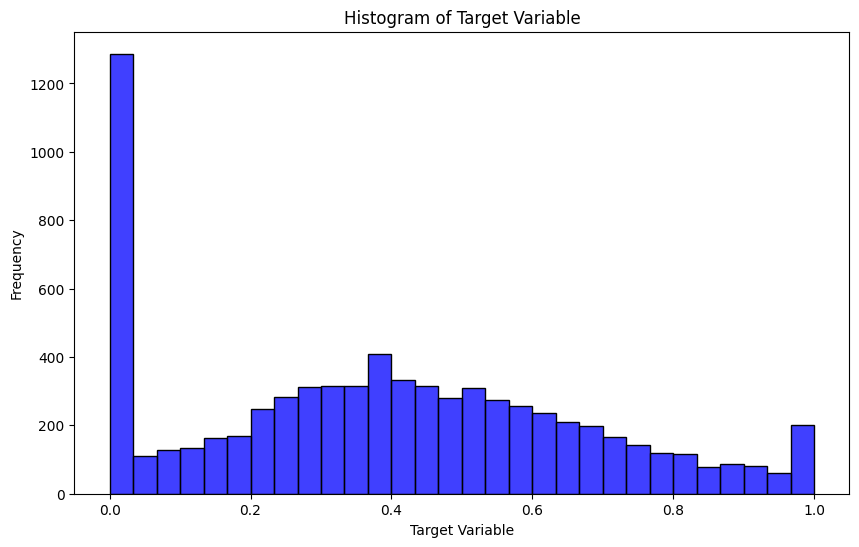

In [406]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values.flatten(), bins=30, kde=False, color='blue')
plt.title('Histogram of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

In [407]:
y_train.value_counts()

target  
0.000000    1207
1.000000     168
0.349999      56
0.374999      51
0.324999      47
            ... 
0.282986       1
0.282692       1
0.282500       1
0.282399       1
0.363435       1
Name: count, Length: 2476, dtype: int64

As seen in the histogram, and now confirmed with value counts, y = 0.0 occurs much more frequently than other values - the target variable is imbalanced, which may pose a problem later on if not dealt with wisely.

In [408]:
X_train.columns[X_train.isnull().any()]

Index([], dtype='object')

No columns with missing values.

In [409]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Columns: 2132 entries, D00 to FP2088
dtypes: float64(2132)
memory usage: 119.3 MB


Columns consist of type 'float64' only. Let's further inspect this.

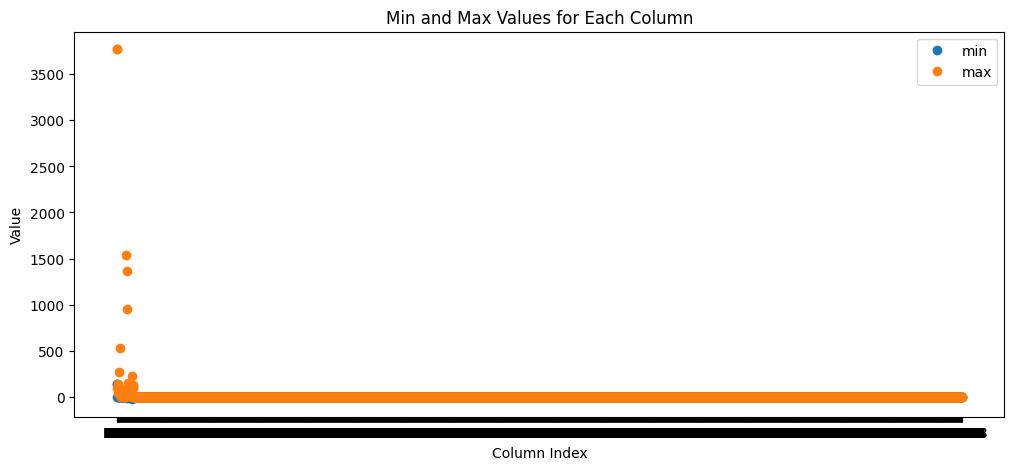

In [410]:
plt.figure(figsize=(12, 5))
plt.plot(X_train.min(axis=0), 'o', label="min") 
plt.plot(X_train.max(axis=0), 'o', label="max")
plt.title('Min and Max Values for Each Column')
plt.legend(loc="best")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.show()

While some columns are indeed floats, the majority seem to be binary and not floats as originally encoded.

In [411]:
binary_filter = X_train.apply(lambda col: set(col) == {0, 1}) #columns containing only 0s and 1s
binary_columns = X_train.columns[binary_filter].tolist()
X_train[binary_columns] = X_train[binary_columns].astype('category')

binary_df = X_train[binary_columns]
binary_df.shape

(7337, 2090)

Training set consisting of binary columns only, all of type 'category'. 2090 samples.

In [412]:
float_filter = ~X_train.columns.isin(binary_columns) #remaining columns (not in binary_columns)
float_columns = X_train.columns[float_filter].tolist()

float_df = X_train[float_columns]
float_df.shape

(7337, 42)

Training set consisting of all remaining columns of type 'float64'. 42 samples.

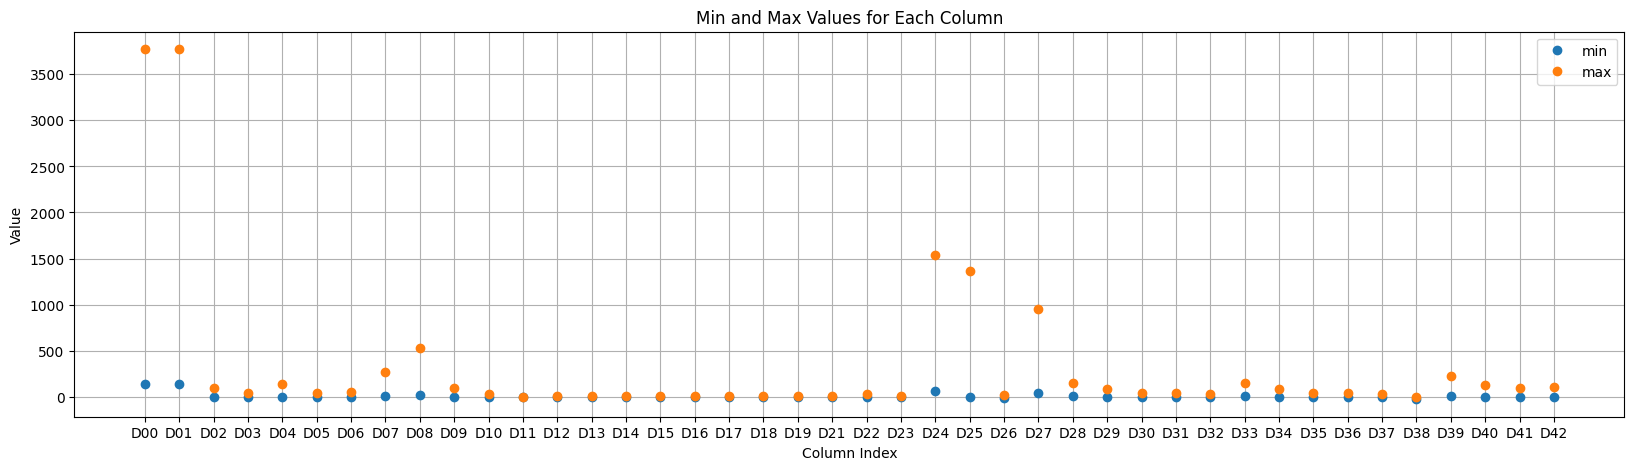

In [413]:
plt.figure(figsize=(20, 5))
plt.plot(float_df.min(axis=0), 'o', label="min") 
plt.plot(float_df.max(axis=0), 'o', label="max")
plt.legend(loc="best")
plt.grid()
plt.title("Min and Max Values for Each Column")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.show()

As there seems to be an overlap of min and max values for some columns, let's double check everything is correct with these columns.

In [414]:
results = []
for col in float_df:
    min_val = float_df[col].min()
    max_val = float_df[col].max()
    results.append((col, min_val, max_val))

check = pd.DataFrame(results, columns=['column', 'min', 'max'])
check

,column,min,max
0,D00,135.068414,3768.848446
1,D01,135.166000,3771.262000
2,D02,1.000000,92.000000
3,D03,0.000000,47.000000
4,D04,0.000000,137.000000
5,D05,0.000000,42.000000
6,D06,0.000000,58.000000
7,D07,10.000000,266.000000
8,D08,19.000000,527.000000
9,D09,1.000000,93.000000


In [ ]:
check[(check['min'] == 0) & (check['max'] == 1)]

Column D11 could be binary instead. Let's plot its distribution.

In [ ]:
X_train['D11'].hist(bins=20)
plt.title(f'Distribution of D11')
plt.xlabel('Column D11')
plt.ylabel('Frequency')
plt.show()

D11 is continuous.


In [415]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Columns: 2132 entries, D00 to FP2088
dtypes: category(2090), float64(42)
memory usage: 17.2 MB


2090 columns of type 'category' and 42 of type 'float64', as intended.

# Methodology 

Due to the way the daset is structured, we will be using a two-step approach to the problem. First, we will use the 2090 columns of type 'category' to train a model, and then use the 42 columns of type 'float64' to train a second model. Finally, we will combine the predictions of both models to obtain the final result.

- The categorical columns will be named "Binary"

- The float columns will be named "Float"


Given the nature of this dataset with a large number of zeros on the target variable, we will devide the dataset into two parts, classification and regression. The classification part will be used to predict the probability of the target variable being 0 or diferent than 0. The regression part will be used to predict the value of the target variable when it is different than 0. So we will a:
- Classification model
- Regression model.

# Classification models

In [416]:
def classification_evaluation(y_test_clf, predictions):

    accuracy = accuracy_score(y_test_clf, predictions)
    precision = precision_score(y_test_clf, predictions)
    recall = recall_score(y_test_clf, predictions)
    f1 = f1_score(y_test_clf, predictions)
    mcc = matthews_corrcoef(y_test_clf, predictions)

    results = {'Test Accuracy': [accuracy], 'Test Precision': [precision], 'Test Recall': [recall], 'Test F1': [f1], 'Test MCC': [mcc]} 
    results_df = pd.DataFrame(results)
    
    return results_df

def classification_model_evaluation(X_train, X_test, y_train, y_test, classifiers):
    
    results_list = []
    for name, (classifier, param_grid) in classifiers.items():
        clf = classifier()
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_micro', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        predictions = best_model.predict(X_test)
        results = classification_evaluation(y_test, predictions)
        results_dict = {'Classifier': name, 'Best Params': best_params}
        results_dict.update(results.iloc[0].to_dict())  # Add evaluation metrics to the results_dict
        results_list.append(results_dict)
    
    results_df = pd.DataFrame(results_list)
    return results_df


classifier_params = {
    'Logistic Regression': (LogisticRegression, {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'max_iter': [1000]}),
    'SVM': (SVC, {'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}),
    'Decision Tree': (DecisionTreeClassifier, {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'Random Forest': (RandomForestClassifier, {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'LightGBM': (LGBMClassifier, {'n_estimators': [50, 100, 200, 500, 600], 'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80], 'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]}),

}



In [417]:
def runner(scaler, model, X_train, y_train, X_test):
    scaler.fit(X_train)
    Xt_train = scaler.transform(X_train)
    Xt_test = scaler.transform(X_test)

    model.fit(Xt_train, y_train)
    preds = model.predict(Xt_test)
    return preds

def sc_tester(model, X_train, y_train, X_test, y_test):      
    scalers = [StandardScaler(), MinMaxScaler(), PowerTransformer(), RobustScaler()]
    results = []

    for scaler in scalers:
        preds = runner(scaler, model, X_train, y_train, X_test)

        f1 = f1_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average="weighted")
        recall = recall_score(y_test, preds, average="weighted")
        mcc = matthews_corrcoef(y_test, preds)

        result_dict = {
            'Scaler': str(scaler),
            'Model': str(model),
            'F1 Score': f1,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'MCC': mcc
        }

        results.append(result_dict)
        
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['MCC'], ascending=False)

    empty_row = pd.Series([" "] * len(results_df.columns), index=results_df.columns)
    results_df.loc[len(results_df)] = empty_row
    
    return results_df

### Create the dataset for the classification model

In [418]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

X_train= pd.DataFrame(X_train, columns=col_names)
y_train = pd.DataFrame(y_train, columns=['Target'])

In [419]:
def binary(row):
    if row['Target'] == 0:
        return 1
    else:
        return 0

In [420]:
y_train_class = y_train.copy()
y_train_class['Target'] = y_train_class.apply(binary, axis=1) # convert to binary
y_train_class = y_train_class.astype('category')

### Binary

In [421]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

binary_x = X_train[binary_columns_train].copy()
binary_y = y_train_class.copy()

# Split data into train and test
X_train_bin_cl, X_test_bin_cl, y_train_bin_cl, y_test_bin_cl = train_test_split(binary_x, binary_y, test_size=0.2, random_state=23)

### Floats

In [422]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

float_x = X_train.drop(binary_columns_train, axis=1).copy()
float_y = y_train_class.copy()

# Split data into train and test
X_train_float_cl, X_test_float_cl, y_train_float_cl, y_test_float_cl = train_test_split(float_x, float_y, test_size=0.2, random_state=23)

## Binary models

### SMOTE

In [423]:
sm = SMOTE(random_state=23)
X_train_bin_resampled, y_train_bin_resampled = sm.fit_resample(X_train_bin_cl, y_train_bin_cl)
results_bin_cl = classification_model_evaluation(X_train_bin_resampled, X_test_bin_cl, y_train_bin_resampled, y_test_bin_cl, classifier_params)
results_bin_cl

,Classifier,Best Params,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,Logistic Regression,"{'C': 10.0, 'max_iter': 1000}",0.84673,0.5,0.564444,0.530271,0.440249


In [424]:
results_bin_cl_2 = classification_model_evaluation(X_train_bin_cl, X_test_bin_cl, y_train_bin_cl, y_test_bin_cl, classifier_params)
results_bin_cl_2

,Classifier,Best Params,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,Logistic Regression,"{'C': 0.1, 'max_iter': 1000}",0.887602,0.689873,0.484444,0.569191,0.517304


bla bla bla the best one is bla bla bla

# Float models

As previously inspected, these columns have quite different distributions and ranges, which means that scaling them is an important step. Let's try different scalers and see how they behave with different classifiers.

In [425]:
rfc_scaler_float = sc_tester(RandomForestClassifier(), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)

lg_scaler_float = sc_tester(LogisticRegression(max_iter=10000), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)

lgbm_scaler_float = sc_tester(LGBMClassifier(verbose = -1), X_train_bin_cl, y_train_bin_cl, X_test_bin_cl, y_test_bin_cl)

In [426]:
full_df= pd.concat([rfc_scaler_float, lg_scaler_float, lgbm_scaler_float])
full_df.head(len(full_df))

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
0,StandardScaler(),RandomForestClassifier(),0.466472,0.875341,0.859697,0.875341,0.430607
1,MinMaxScaler(),RandomForestClassifier(),0.442478,0.871253,0.853762,0.871253,0.406454
3,RobustScaler(),RandomForestClassifier(),0.441176,0.870572,0.852816,0.870572,0.403754
2,PowerTransformer(),RandomForestClassifier(),0.434524,0.870572,0.852686,0.870572,0.400438
4,,,,,,,
2,PowerTransformer(),LogisticRegression(max_iter=10000),0.133858,0.850136,0.814188,0.850136,0.170605
3,RobustScaler(),LogisticRegression(max_iter=10000),0.090164,0.848774,0.810413,0.848774,0.135308
0,StandardScaler(),LogisticRegression(max_iter=10000),0.082645,0.848774,0.811426,0.848774,0.130691
1,MinMaxScaler(),LogisticRegression(max_iter=10000),0.034632,0.848093,0.820916,0.848093,0.091297
4,,,,,,,


In [427]:
scaler_float = PowerTransformer()
X_train_float_scaled = scaler_float.fit_transform(X_train_float_cl)
X_test_float_scaled = scaler_float.transform(X_test_float_cl)

sm = SMOTE(random_state=23)
X_train_float_resampled, y_train_float_resampled = sm.fit_resample(X_train_float_scaled, y_train_float_cl)
results_float = classification_model_evaluation(X_train_float_resampled, X_test_float_scaled, y_train_float_resampled, y_test_float_cl, classifier_params)
results_float

,Classifier,Best Params,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,Logistic Regression,"{'C': 1.0, 'max_iter': 1000}",0.66485,0.268631,0.688889,0.386534,0.257696


In [428]:
pca = PCA(n_components=0.9) #to retain 90% of the original variance
X_train_float_pca = pca.fit_transform(X_train_float_resampled)
X_test_float_pca = pca.transform(X_test_float_scaled)

model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40,verbose = -1) #apparent best classifier
model.fit(X_train_float_pca, y_train_float_resampled)

preds_pca = model.predict(X_test_float_pca)
classification_evaluation(y_test_float_cl, preds_pca)

,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,0.840599,0.484429,0.622222,0.544747,0.455122


bla bla bla the best one is bla bla bla

# Regression models

In [429]:
def regression_evaluation_df(truth, preds):
    rve = explained_variance_score(truth, preds)
    rmse = mean_squared_error(truth, preds, squared=False)
    max_err = max_error(truth, preds)
    mae = mean_absolute_error(truth, preds)

    results = {'Test RVE': [rve], 'Test RMSE': [rmse], 
               'Test Maximum Error': [max_err], 'Test MAE': [mae]} 
    results_df = pd.DataFrame(results)

    return results_df

def clipper(array):
    for i in range(len(array)):
        if array[i] < 0:
            array[i] = 0
        elif array[i] > 1:
            array[i] = 1
    return array

def regression_model_evaluation(X_train, X_test, y_train, y_test, models, classifier):

    final_results = pd.DataFrame()

    for name, regressor in models.items():

        zir = ZeroInflatedRegressor(
            classifier=classifier,
            regressor=regressor
        )

        zir.fit(X_train, y_train)
        y_pred = zir.predict(X_test)
        y_pred = clipper(y_pred)

        result= regression_evaluation_df(y_test, y_pred)
        result.rename(index={0: name}, inplace=True)
        final_results = pd.concat([final_results, result])


    return final_results

models={'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(random_state=23),
        'XGBoost Regression': XGBRegressor(random_state=23),
        'SVR': SVR(),
        'Decision Tree': DecisionTreeRegressor(  random_state=23),
 }



for i in (100,200,300,500,800,1000):
    for j in [None,2,4,8,10,20,30]:
        for k in [None,2,4,5,8,10]:
            models[f'Random Forest  n_estimators={i}, max_depth={j}'] = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=23)

for i in (100,200,300,500,800,1000):
    for j in [None,2,4,8,10,20,30]:
        for k in [None,2,4,5,8,10]:
            for l in [None, 0.001, 0.01, 0.1, 1.0]:
                models[f'LightGBM  n_estimators={i}, max_depth={j}'] = LGBMRegressor(n_estimators=i, max_depth=j, random_state=23,)
                models[f'XBoost  n_estimators={i}, max_depth={j}'] = XGBRegressor(n_estimators=i, max_depth=j, random_state=23)

## Create the dataset for the regression models

In [430]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

X_train= pd.DataFrame(X_train, columns=col_names)
y_train = pd.DataFrame(y_train, columns=['Target'])

### Binary

In [431]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

binary_x = X_train[binary_columns_train].copy()
binary_y = y_train.copy()

# Split data into train and test
X_train_bin_reg, X_test_bin_reg, y_train_bin_reg, y_test_bin_reg = train_test_split(binary_x, binary_y, test_size=0.2, random_state=23)

### Floats

In [432]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

float_x = X_train.drop(binary_columns_train, axis=1).copy()
float_y = y_train.copy()

# Split data into train and test
X_train_float_reg, X_test_float_reg, y_train_float_reg, y_test_float_reg = train_test_split(float_x, float_y, test_size=0.2, random_state=23)

## Binary models

In [433]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=23) # aqui pomos o melhor classifier que encontramos!!!!!!!!!!!!!
results_float=regression_model_evaluation(X_train_bin_reg, X_test_bin_reg, y_train_bin_reg, y_test_bin_reg, models, classifier)
results_float.sort_values(by='Test RVE',ascending=False, inplace=True)
results_float.head(10)

,Test RVE,Test RMSE,Test Maximum Error,Test MAE
SVR,0.610817,0.173670,0.712040,0.126033
XGBoost Regression,0.596943,0.176008,0.759213,0.126545
Ridge Regression,0.480891,0.198552,0.928301,0.141634
Linear Regression,0.437689,0.206510,1.000000,0.147091
Decision Tree,0.381363,0.218018,1.000000,0.149784


## Float models

In [434]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=23) # aqui pomos o melhor classifier que encontramos!!!!!!!!!!!!!
results_float=regression_model_evaluation(X_train_float_reg, X_test_float_reg, y_train_float_reg, y_test_float_reg, models, classifier)
results_float.sort_values(by='Test RVE',ascending=False, inplace=True)
results_float.head(10)

,Test RVE,Test RMSE,Test Maximum Error,Test MAE
XGBoost Regression,0.373324,0.218634,0.694451,0.161320
Linear Regression,0.157965,0.253532,0.693320,0.198914
Ridge Regression,0.157703,0.253573,0.692082,0.198993
SVR,0.128123,0.256855,0.649995,0.203641
Decision Tree,0.040604,0.270273,1.000000,0.192029


# Stack model

now we will make the predictions with the best models and stack them together

In [435]:
X_train_bin_stack, X_test_bin_stack, y_train_bin_stack, y_test_bin_stack = train_test_split(binary_x, binary_y, test_size=0.3, random_state=23)
X_train_float_stack, X_test_float_stack, y_train_float_stack, y_test_float_stack = train_test_split(float_x, float_y, test_size=0.3, random_state=23)

In [436]:
model_bin=ZeroInflatedRegressor(
    classifier=LGBMClassifier(n_estimators=100, max_depth=None, random_state=23,verbose = -1),
    regressor=LGBMRegressor(n_estimators=100, max_depth=None, random_state=23,verbose = -1)
)

model_bin.fit(X_train_bin_stack, y_train_bin_stack)
y_pred_bin = model_bin.predict(X_test_bin_stack)

In [437]:
scaler=StandardScaler()
X_train_float_stack = scaler.fit_transform(X_train_float_stack)
X_test_float_stack = scaler.transform(X_test_float_stack)

In [438]:
model_float=ZeroInflatedRegressor(
    classifier=LGBMClassifier(n_estimators=100, max_depth=None, random_state=23,verbose = -1),
    regressor=LGBMRegressor(n_estimators=100, max_depth=None, random_state=23,verbose = -1)
)

model_float.fit(X_train_float_stack, y_train_float_stack)
y_pred_float = model_float.predict(X_test_float_stack)

In [439]:
x_new=pd.concat([pd.DataFrame(y_pred_bin),pd.DataFrame(y_pred_float)],axis=1)
x_new.columns=['Binary','Float']

y_new=y_test_bin_stack.copy()

## Train and test the stack model

In [440]:
x_train_stack, x_test_stack, y_train_stack, y_test_stack = train_test_split(x_new, y_new, test_size=0.3, random_state=23)

In [441]:
classifier = LGBMClassifier(n_estimators=200, random_state=23,verbose = -1) # aqui pomos o melhor classifier que encontramos!!!!!!!!!!!!!
stack_reg_results=regression_model_evaluation(x_train_stack, x_test_stack, y_train_stack, y_test_stack, models, classifier)
stack_reg_results.sort_values(by='Test RVE',ascending=False, inplace=True)
stack_reg_results.head(10)

,Test RVE,Test RMSE,Test Maximum Error,Test MAE
SVR,0.518399,0.182382,0.806920,0.131084
Linear Regression,0.509901,0.184139,0.806920,0.131176
Ridge Regression,0.508990,0.184320,0.806920,0.131538
XGBoost Regression,0.397183,0.204138,0.858406,0.150543
Decision Tree,0.207517,0.234119,1.000000,0.174470


In [442]:
best_model=LinearRegression()

best_model.fit(x_train_stack, y_train_stack)

LinearRegression()

# Submission

In [443]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

X_train= pd.DataFrame(X_train, columns=col_names)
y_train = pd.DataFrame(y_train, columns=['Target'])
X_ivs= pd.DataFrame(X_ivs,columns=col_names)

In [444]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

binary_x = X_train[binary_columns_train].copy()
float_x = X_train.drop(binary_columns_train, axis=1).copy()

binary_x_ivs = X_ivs[binary_columns_train].copy()
float_x_ivs = X_ivs.drop(binary_columns_train, axis=1).copy()

### Binary

In [445]:
model=ZeroInflatedRegressor(
    classifier=LGBMClassifier(n_estimators=100, max_depth=None, random_state=23, verbose = -1),
    regressor=LGBMRegressor(n_estimators=100, max_depth=None, random_state=23, verbose = -1)
)

model.fit(binary_x, y_train)
y_pred_bin = model.predict(binary_x_ivs)

### Float

In [446]:
model=ZeroInflatedRegressor(
    classifier=LGBMClassifier(n_estimators=100, max_depth=None, random_state=23,verbose = -1),
    regressor=LGBMRegressor(n_estimators=100, max_depth=None, random_state=23,verbose = -1)
)

model.fit(float_x, y_train)
y_pred_float = model.predict(float_x_ivs)

### Stacked

In [447]:
new_x=pd.concat([pd.DataFrame(y_pred_bin),pd.DataFrame(y_pred_float)],axis=1)
new_x.columns=['Binary','Float']

final_preds=best_model.predict(new_x)
final_preds=clipper(final_preds)

In [448]:
#export the final predictions as csv
final_preds=pd.DataFrame(final_preds)
final_preds.to_csv('final_preds.csv', index=False, header=False)

### Em princípio é isto